In [3]:
# --- 1. Cài đặt & Thư viện ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings
import os

# Thư viện Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Thư viện XGBoost
import xgboost as xgb

# Cài đặt chung
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
# --- 2. Tải và Chuẩn bị Dữ liệu ---
try:
    # Tải dữ liệu đã được feature engineering
    df = pd.read_csv('clean_student_data_v1.csv')
    print("Tải dữ liệu từ 'clean_student_data_v1.csv' thành công.")
    TARGET_COLUMN = ['weekly_study_hours','attendance_percentage']
    df['raw_score_x_part_time_hours'] = df['raw_score'] * df['part_time_hours']
    df['raw_score_x_financial_support'] = df['raw_score'] * df['financial_support']
    df['raw_score_x_emotional_support'] = df['raw_score'] * df['emotional_support']
    df['raw_score_x_part_time_financial'] = df['raw_score'] * df['part_time_hours'] * df['financial_support']
    DROP_COLUMNS = [
        'weekly_study_hours','attendance_percentage',
        'study_hours_x_attendance',
        'full_interaction_feature',
        'expected_score_hint',
        'student_id', 'year',
        'cumulative_gpa', 'current_semester_gpa',
        'previous_courses_taken', 'previous_credits_earned',
        'expected_difficulty', 'subject_type','fail_rate_general','fail_rate_major','study_hours_x_part_part_time_hours',
        'attendance_x_emotional_support'
    ]
    X = df.drop(columns=DROP_COLUMNS)
    y = df[TARGET_COLUMN]

    # Chia tập train/test trước khi xử lý để tránh data leakage
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # --- 3. Xây dựng Pipeline xử lý hoàn chỉnh (bao gồm cả Scaling) ---
    categorical_features = X_train.select_dtypes(include=['object', 'category']).columns
    numerical_features = X_train.select_dtypes(include=np.number).columns
    
    # Tạo các bước xử lý
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    numerical_transformer = StandardScaler() # Chuẩn hóa các đặc trưng số
    
    # Kết hợp các bước xử lý bằng ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numerical_transformer, numerical_features)
        ],
        remainder='passthrough'
    )
    
    # Tạo pipeline chỉ chứa bước tiền xử lý
    preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
    
    # Fit pipeline trên tập train và biến đổi cả 2 tập
    X_train_transformed = preprocessing_pipeline.fit_transform(X_train)
    X_test_transformed = preprocessing_pipeline.transform(X_test)
    
    # Lấy tên các đặc trưng sau khi đã biến đổi
    feature_names = preprocessing_pipeline.named_steps['preprocessor'].get_feature_names_out()

    print(f"Dữ liệu đã được chuẩn hóa và sẵn sàng. Kích thước X_train_transformed: {X_train_transformed.shape}")

except FileNotFoundError:
    print("Lỗi: Không tìm thấy file 'clean_student_data_v1.csv'.")
    X_train_transformed = None

Tải dữ liệu từ 'clean_student_data_v1.csv' thành công.
Dữ liệu đã được chuẩn hóa và sẵn sàng. Kích thước X_train_transformed: (272000, 74)


In [4]:
# Huấn luyện pipeline trên dữ liệu training
print("Đang huấn luyện pipeline trên X_train...")
preprocessing_pipeline.fit(X_train)
print("Huấn luyện hoàn tất.")

# Lưu pipeline đã được huấn luyện ra file joblib
pipeline_filename = 'preprocessing_pipeline_reverse_2_8_2025_1.joblib'
joblib.dump(preprocessing_pipeline, pipeline_filename)

print(f"\nToàn bộ pipeline đã được lưu thành công vào file: '{pipeline_filename}'")
display(preprocessing_pipeline)

Đang huấn luyện pipeline trên X_train...
Huấn luyện hoàn tất.

Toàn bộ pipeline đã được lưu thành công vào file: 'preprocessing_pipeline_reverse_2_8_2025_1.joblib'


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['course_code', 'study_format'], dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['semester_number', 'credits_unit', 'raw_score', 'part_time_hours',
       'financial_support', 'emotional_support',
       'financial_support_x_part_time_hours', 'raw_score_x_part_time_hours',
       'raw_score_x_financial_support', 'raw_score_x_emotional_support',
       'raw_score_x_part_time_financial'],
      dtype='object'))]))])

In [3]:
#tái sử dụng lại
# Giả sử đây là một script khác hoặc một lần chạy sau
print("--- Thử nghiệm nạp và sử dụng lại pipeline ---")

# Tải pipeline từ file
loaded_pipeline = joblib.load(pipeline_filename)
print("Đã tải pipeline từ file.")

# Sử dụng pipeline đã tải để biến đổi dữ liệu test
# Dữ liệu test sẽ được biến đổi theo đúng cách mà dữ liệu train đã được học
X_test_transformed = loaded_pipeline.transform(X_test)

print(f"\nKích thước của X_test gốc: {X_test.shape}")
print(f"Kích thước của X_test sau khi biến đổi qua pipeline: {X_test_transformed.shape}")
print("Biến đổi thành công! Dữ liệu đã sẵn sàng để đưa vào mô hình.")

--- Thử nghiệm nạp và sử dụng lại pipeline ---
Đã tải pipeline từ file.

Kích thước của X_test gốc: (67000, 10)
Kích thước của X_test sau khi biến đổi qua pipeline: (67000, 71)
Biến đổi thành công! Dữ liệu đã sẵn sàng để đưa vào mô hình.


In [4]:
# === PHẦN 0: CÀI ĐẶT & THƯ VIỆN ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display
import joblib
# Thư viện Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Thư viện XGBoost
import xgboost as xgb

# Cài đặt chung
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'sans-serif'


# === PHẦN 1: TẢI VÀ TIỀN XỬ LÝ DỮ LIỆU ===
data_loaded_successfully = False
try:
    df = pd.read_csv('clean_student_data_v1.csv')
    print("Tải dữ liệu từ 'clean_student_data_v1.csv' thành công.")
    TARGET_COLUMN = 'weekly_study_hours'
    DROP_COLUMNS = [
    'weekly_study_hours',
    'study_hours_x_attendance',
    'full_interaction_feature',
    'expected_score_hint',
    'student_id', 'year',
    'cumulative_gpa', 'current_semester_gpa',
    'previous_courses_taken', 'previous_credits_earned',
    'expected_difficulty', 'subject_type','fail_rate_general','fail_rate_major','study_hours_x_part_part_time_hours'
    ]
    X = df.drop(columns=DROP_COLUMNS)
    y = df[TARGET_COLUMN]
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Đã chia dữ liệu: {X_train_raw.shape[0]} mẫu huấn luyện, {X_test_raw.shape[0]} mẫu kiểm tra.")
    
    categorical_features = X_train_raw.select_dtypes(include=['object', 'category']).columns
    numerical_features = X_train_raw.select_dtypes(include=np.number).columns
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    numerical_transformer = StandardScaler()
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numerical_transformer, numerical_features)
        ],
        remainder='passthrough'
    )
    X_train = preprocessor.fit_transform(X_train_raw)
    X_test = preprocessor.transform(X_test_raw)
    feature_names = preprocessor.get_feature_names_out()
    print(f"Dữ liệu đã được mã hóa và chuẩn hóa. Kích thước X_train mới: {X_train.shape}")
    data_loaded_successfully = True

except FileNotFoundError:
    print("\nLỖI: Không tìm thấy file 'clean_student_data_v1.csv'.\n")

# === TOÀN BỘ QUY TRÌNH HUẤN LUYỆN CHỈ CHẠY KHI DỮ LIỆU TẢI THÀNH CÔNG ===
if data_loaded_successfully:
    # === PHẦN 2: CẢI TIẾN VÀ HUẤN LUYỆN MÔ HÌNH ===
    print("\n---Bắt đầu tối ưu mô hình XGBoost ---")
    param_grid_xgb = {
        'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0, 0.1, 1], 'reg_lambda': [1, 10, 100]
    }
    xgb_model_base = xgb.XGBRegressor(
        objective='reg:squarederror', learning_rate=0.05, max_depth=5,
        random_state=42, n_jobs=-1, n_estimators=500
    )
    grid_search_xgb = GridSearchCV(
        estimator=xgb_model_base, param_grid=param_grid_xgb, cv=5,
        scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1
    )
    grid_search_xgb.fit(X_train, y_train)
    print(f"\nCác tham số XGBoost tốt nhất tìm được: {grid_search_xgb.best_params_}")
    
    print("--- Huấn luyện mô hình XGBoost cuối cùng với Early Stopping ---")
    best_xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror', n_estimators=1000, learning_rate=0.05,
        max_depth=5, random_state=42, n_jobs=-1,
        early_stopping_rounds=20, **grid_search_xgb.best_params_
    )
    best_xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    print("\n---Bắt đầu tối ưu mô hình MLPRegressor ---")
    param_grid_mlp = {
        'hidden_layer_sizes': [(128,), (128, 64), (256, 128, 64)],
        'solver': ['adam'], 'learning_rate_init': [0.001, 0.01], 'alpha': [0.0001, 0.001]
    }
    mlp_model_base = MLPRegressor(random_state=42, max_iter=1000, early_stopping=True)
    grid_search_mlp = GridSearchCV(
        estimator=mlp_model_base, param_grid=param_grid_mlp, cv=5,
        scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1
    )
    grid_search_mlp.fit(X_train, y_train)
    best_mlp_model = grid_search_mlp.best_estimator_
    print(f"\nCác tham số MLPRegressor tốt nhất tìm được: {grid_search_mlp.best_params_}")

    # === PHẦN 3: ĐÁNH GIÁ ĐỘ CHÍNH XÁC SAU TỐI ƯU ===
    print("\n--- Đánh giá độ chính xác trên tập Test ---")
    trained_models = {
        "XGBoost Tối ưu": best_xgb_model, "MLPRegressor Tối ưu": best_mlp_model
    }
    evaluation_results = []
    for model_name, model in trained_models.items():
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        
        # SỬA LỖI: Thay thế cách tính RMSE để tương thích với mọi phiên bản sklearn
        # Dòng mã cũ: rmse = mean_squared_error(y_test, y_pred, squared=False)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        r2 = r2_score(y_test, y_pred)
        evaluation_results.append({"Mô hình": model_name, "MAE": mae, "RMSE": rmse, "R² Score": r2})
        print(f"Kết quả cho {model_name}:\n  - MAE: {mae:.4f}\n  - RMSE: {rmse:.4f}\n  - R² Score: {r2:.4f}\n")
    eval_df = pd.DataFrame(evaluation_results)

Tải dữ liệu từ 'clean_student_data_v1.csv' thành công.
Đã chia dữ liệu: 268000 mẫu huấn luyện, 67000 mẫu kiểm tra.
Dữ liệu đã được mã hóa và chuẩn hóa. Kích thước X_train mới: (268000, 71)

---Bắt đầu tối ưu mô hình XGBoost ---
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Các tham số XGBoost tốt nhất tìm được: {'colsample_bytree': 1.0, 'reg_alpha': 1, 'reg_lambda': 10, 'subsample': 0.8}
--- Huấn luyện mô hình XGBoost cuối cùng với Early Stopping ---

---Bắt đầu tối ưu mô hình MLPRegressor ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Các tham số MLPRegressor tốt nhất tìm được: {'alpha': 0.0001, 'hidden_layer_sizes': (256, 128, 64), 'learning_rate_init': 0.01, 'solver': 'adam'}

--- Đánh giá độ chính xác trên tập Test ---
Kết quả cho XGBoost Tối ưu:
  - MAE: 3.7926
  - RMSE: 4.9074
  - R² Score: 0.6835

Kết quả cho MLPRegressor Tối ưu:
  - MAE: 3.7913
  - RMSE: 4.8972
  - R² Score: 0.6848



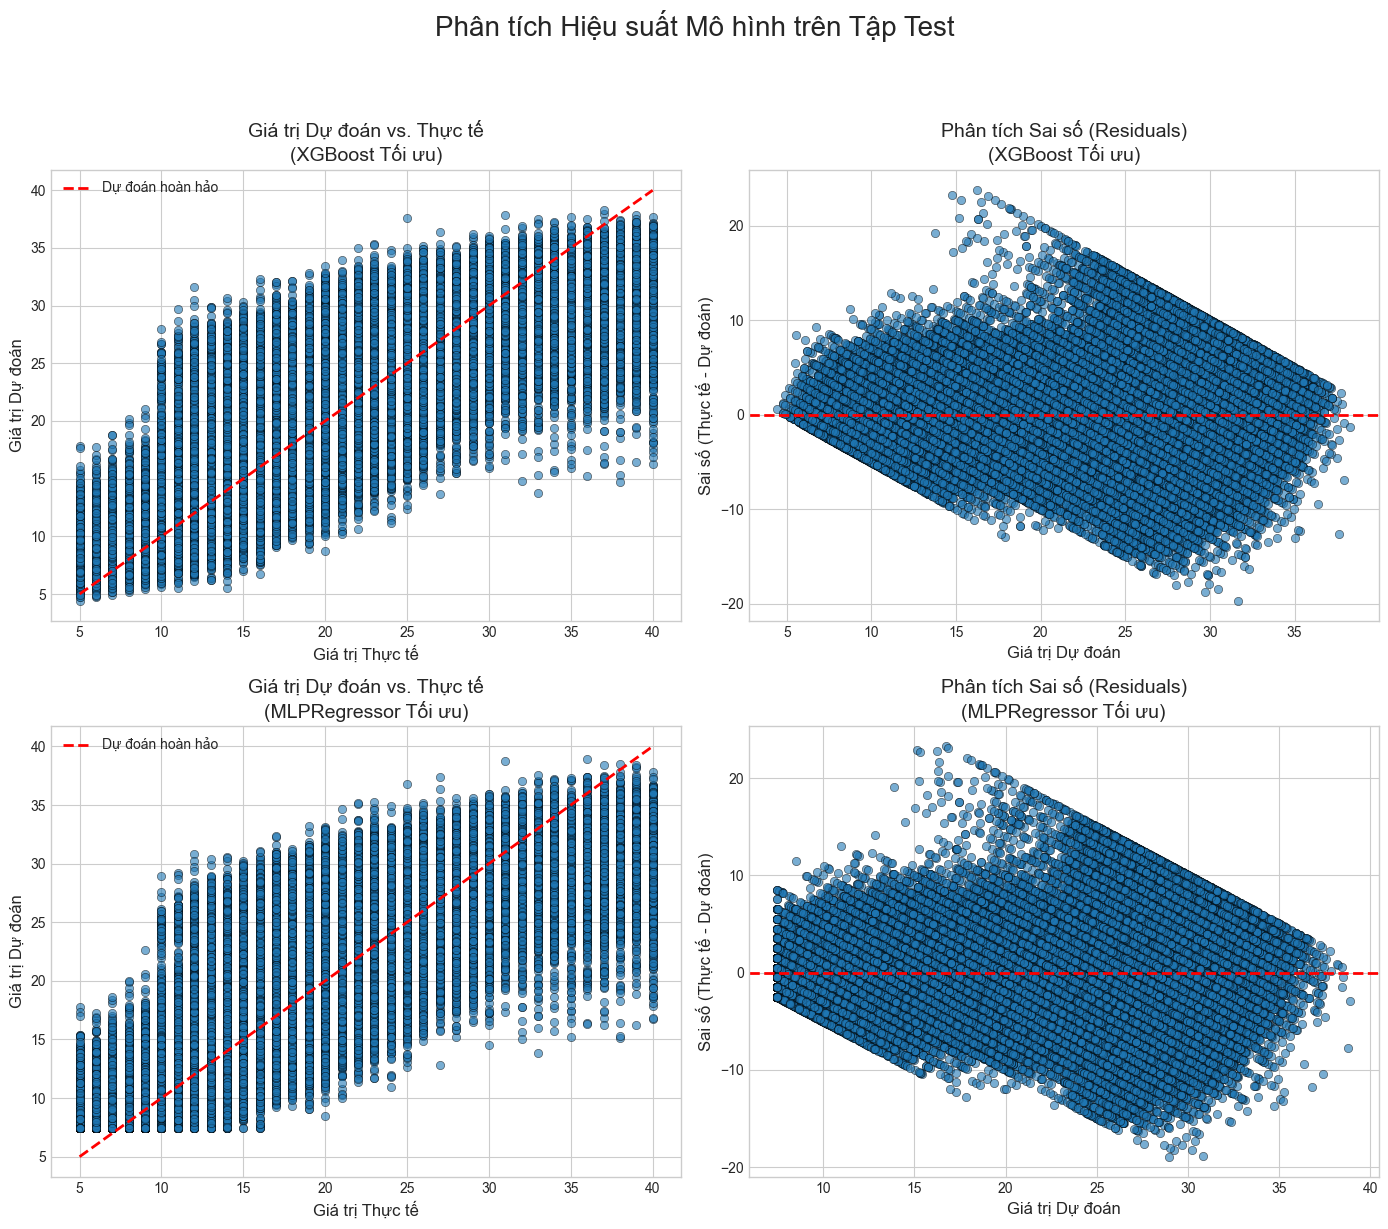

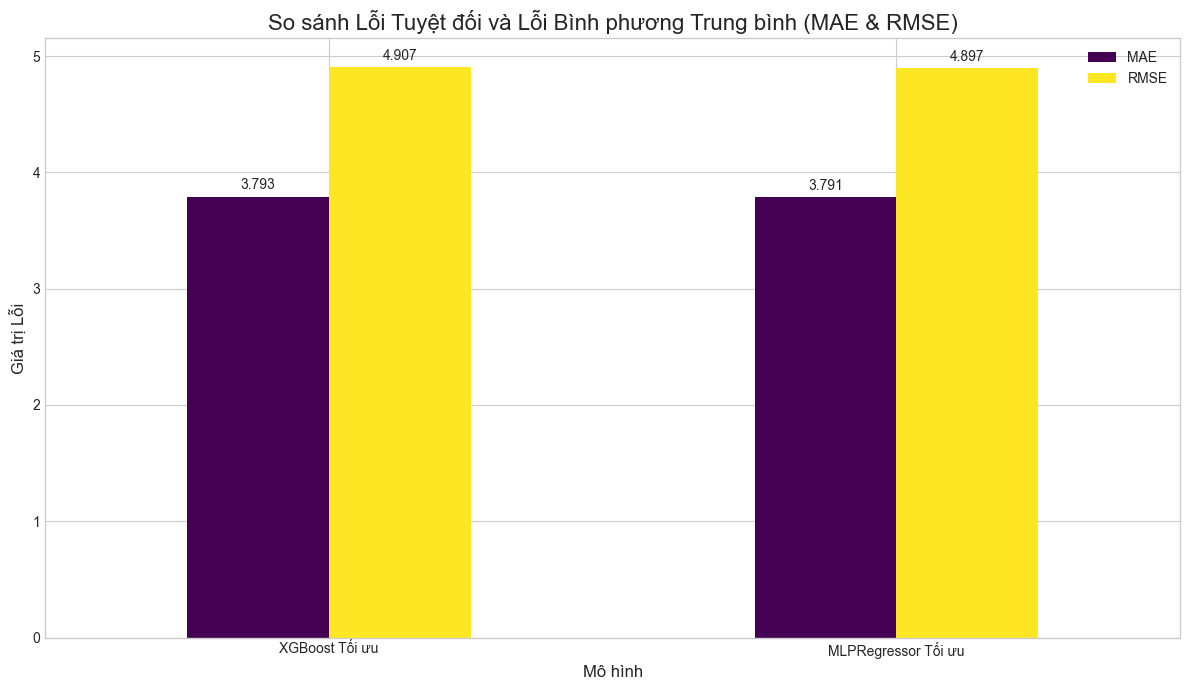

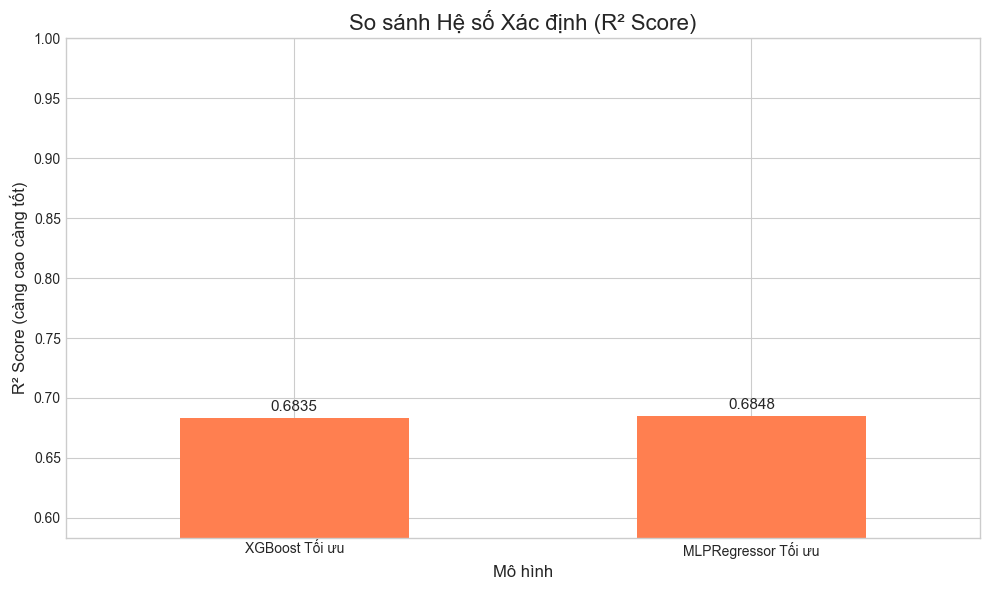


---Bảng tổng kết so sánh hiệu suất ---


,MAE,RMSE,R² Score
Mô hình,,,
XGBoost Tối ưu,3.7926,4.9074,0.6835
MLPRegressor Tối ưu,3.7913,4.8972,0.6848


In [6]:
    # === PHẦN 4: BIỂU DIỄN KẾT QUẢ TRỰC QUAN ===
    # (Phần này không thay đổi, giữ nguyên như cũ)
    n_models = len(trained_models)
    fig, axes = plt.subplots(n_models, 2, figsize=(14, 6 * n_models), squeeze=False)
    fig.suptitle('Phân tích Hiệu suất Mô hình trên Tập Test', fontsize=20, y=1.02)
    for i, (model_name, model) in enumerate(trained_models.items()):
        y_pred = model.predict(X_test)
        residuals = y_test - y_pred
        ax_scatter = axes[i, 0]
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, ax=ax_scatter, edgecolor='k')
        perfect_line = np.linspace(min(y_test), max(y_test), 100)
        ax_scatter.plot(perfect_line, perfect_line, 'r--', lw=2, label='Dự đoán hoàn hảo')
        ax_scatter.set_title(f'Giá trị Dự đoán vs. Thực tế\n({model_name})', fontsize=14)
        ax_scatter.set_xlabel('Giá trị Thực tế', fontsize=12)
        ax_scatter.set_ylabel('Giá trị Dự đoán', fontsize=12)
        ax_scatter.legend()
        ax_scatter.grid(True)
        ax_residual = axes[i, 1]
        sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, ax=ax_residual, edgecolor='k')
        ax_residual.axhline(y=0, color='r', linestyle='--', lw=2)
        ax_residual.set_title(f'Phân tích Sai số (Residuals)\n({model_name})', fontsize=14)
        ax_residual.set_xlabel('Giá trị Dự đoán', fontsize=12)
        ax_residual.set_ylabel('Sai số (Thực tế - Dự đoán)', fontsize=12)
        ax_residual.grid(True)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    eval_df.set_index('Mô hình', inplace=True)
    ax1 = eval_df[['MAE', 'RMSE']].plot(kind='bar', figsize=(12, 7), rot=0, colormap='viridis')
    ax1.set_title('So sánh Lỗi Tuyệt đối và Lỗi Bình phương Trung bình (MAE & RMSE)', fontsize=16)
    ax1.set_ylabel('Giá trị Lỗi', fontsize=12)
    ax1.set_xlabel('Mô hình', fontsize=12)
    for container in ax1.containers:
        ax1.bar_label(container, fmt='%.3f', fontsize=10, padding=3)
    plt.tight_layout()
    plt.show()

    ax2 = eval_df[['R² Score']].plot(kind='bar', figsize=(10, 6), rot=0, color='coral', legend=False)
    ax2.set_title('So sánh Hệ số Xác định (R² Score)', fontsize=16)
    ax2.set_ylabel('R² Score (càng cao càng tốt)', fontsize=12)
    ax2.set_xlabel('Mô hình', fontsize=12)
    ax2.set_ylim(bottom=max(0, eval_df['R² Score'].min() - 0.1), top=1.0)
    for container in ax2.containers:
        ax2.bar_label(container, fmt='%.4f', fontsize=11, padding=3)
    plt.tight_layout()
    plt.show()

    # === PHẦN 5: HIỂN THỊ BẢNG SO SÁNH CUỐI CÙNG ===
    print("\n---Bảng tổng kết so sánh hiệu suất ---")
    display(eval_df.style.format("{:.4f}").highlight_min(
        subset=['MAE', 'RMSE'], color='#c8e6c9'
    ).highlight_max(
        subset=['R² Score'], color='#c8e6c9'
    ))

In [7]:
# ===================================================================
# === PHẦN 6: LƯU VÀ KIỂM TRA PIPELINE HOÀN CHỈNH                 ===
# ===================================================================
print("\n--- 💾 Bắt đầu lưu và kiểm tra pipeline hoàn chỉnh ---")

    # --- 6.1. Kết hợp preprocessor và model thành một pipeline duy nhất ---
    # `preprocessor` là đối tượng ColumnTransformer đã được fit ở Phần 1
    # `best_xgb_model` và `best_mlp_model` là các mô hình đã được huấn luyện ở Phần 2
    
print("   -> Đang tạo các pipeline hoàn chỉnh (preprocessor + model)...")
xgb_full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_xgb_model)
])

mlp_full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_mlp_model)
])
print("   -> Tạo pipeline hoàn chỉnh thành công.")

# --- 6.2. Lưu các pipeline hoàn chỉnh vào file .joblib ---
xgb_filename = "xgb_final_pipeline_revese.joblib"
mlp_filename = "mlp_final_pipeline_revese.joblib"

joblib.dump(xgb_full_pipeline, xgb_filename)
print(f"   -> Đã lưu pipeline XGBoost vào file: '{xgb_filename}'")
    
joblib.dump(mlp_full_pipeline, mlp_filename)
print(f"   -> Đã lưu pipeline MLPRegressor vào file: '{mlp_filename}'")

# --- 6.3. Kiểm tra lại các file đã lưu để đảm bảo tính toàn vẹn ---
print("\n--- 🔍 Bắt đầu kiểm tra lại các file đã lưu ---")
    
# Tải lại và kiểm tra pipeline của XGBoost
try:
    loaded_xgb_pipeline = joblib.load(xgb_filename)
    # Quan trọng: Dự đoán trên dữ liệu thô (X_test_raw) để kiểm tra toàn bộ pipeline
    xgb_preds_from_loaded = loaded_xgb_pipeline.predict(X_test_raw)
    r2_loaded_xgb = r2_score(y_test, xgb_preds_from_loaded)
        
    print(f"   -> Tải và kiểm tra '{xgb_filename}' thành công.")
    print(f"      R² Score từ pipeline đã tải: {r2_loaded_xgb:.4f}")
        
    # So sánh với kết quả đã tính toán ở Phần 3
    original_r2_xgb = eval_df.loc['XGBoost Tối ưu', 'R² Score']
    assert np.isclose(r2_loaded_xgb, original_r2_xgb), "R² Score không khớp!"
    print("      Kết quả khớp với mô hình gốc. Toàn vẹn dữ liệu được đảm bảo.")

except Exception as e:
    print(f"   -> LỖI khi kiểm tra file XGBoost: {e}")

    # Tải lại và kiểm tra pipeline của MLPRegressor
try:
    loaded_mlp_pipeline = joblib.load(mlp_filename)
    # Quan trọng: Dự đoán trên dữ liệu thô (X_test_raw)
    mlp_preds_from_loaded = loaded_mlp_pipeline.predict(X_test_raw)
    r2_loaded_mlp = r2_score(y_test, mlp_preds_from_loaded)
    
    print(f"\n   -> Tải và kiểm tra '{mlp_filename}' thành công.")
    print(f"      R² Score từ pipeline đã tải: {r2_loaded_mlp:.4f}")

    # So sánh với kết quả đã tính toán ở Phần 3
    original_r2_mlp = eval_df.loc['MLPRegressor Tối ưu', 'R² Score']
    assert np.isclose(r2_loaded_mlp, original_r2_mlp), "R² Score không khớp!"
    print("      Kết quả khớp với mô hình gốc. Toàn vẹn dữ liệu được đảm bảo.")

except Exception as e:
    print(f"   -> LỖI khi kiểm tra file MLPRegressor: {e}")


--- 💾 Bắt đầu lưu và kiểm tra pipeline hoàn chỉnh ---
   -> Đang tạo các pipeline hoàn chỉnh (preprocessor + model)...
   -> Tạo pipeline hoàn chỉnh thành công.
   -> Đã lưu pipeline XGBoost vào file: 'xgb_final_pipeline_revese.joblib'
   -> Đã lưu pipeline MLPRegressor vào file: 'mlp_final_pipeline_revese.joblib'

--- 🔍 Bắt đầu kiểm tra lại các file đã lưu ---
   -> Tải và kiểm tra 'xgb_final_pipeline_revese.joblib' thành công.
      R² Score từ pipeline đã tải: 0.6835
      Kết quả khớp với mô hình gốc. Toàn vẹn dữ liệu được đảm bảo.

   -> Tải và kiểm tra 'mlp_final_pipeline_revese.joblib' thành công.
      R² Score từ pipeline đã tải: 0.6848
      Kết quả khớp với mô hình gốc. Toàn vẹn dữ liệu được đảm bảo.


In [8]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import numpy as np                                  # dùng cho np.isclose

# ------------------------------------------------------------------
# 1️⃣ NẠP PREPROCESSOR ĐÃ LƯU
# ------------------------------------------------------------------
preprocessor = joblib.load("preprocessing_pipeline_reverse.joblib")
print("✅ Đã nạp preprocessing pipeline từ file.")


✅ Đã nạp preprocessing pipeline từ file.


In [9]:
# ------------------------------------------------------------------
# 4️⃣ KIỂM TRA LẠI FILE ĐÃ LƯU
# ------------------------------------------------------------------
loaded_xgb = joblib.load("xgb_final_pipeline_revese.joblib")
loaded_mlp = joblib.load("mlp_final_pipeline_revese.joblib")

# X_test_raw là features CHƯA qua bất kỳ transform nào
xgb_pred = loaded_xgb.predict(X_test_raw)
mlp_pred = loaded_mlp.predict(X_test_raw)

r2_xgb_loaded = r2_score(y_test, xgb_pred)
r2_mlp_loaded = r2_score(y_test, mlp_pred)

print(f"🔍 R² XGB (đã load): {r2_xgb_loaded:.4f}")
print(f"🔍 R² MLP (đã load): {r2_mlp_loaded:.4f}")

# So khớp với bảng eval_df đã tính trước
assert np.isclose(
    r2_xgb_loaded, eval_df.loc["XGBoost Tối ưu", "R² Score"]
), "❌ R² của XGB không khớp!"
assert np.isclose(
    r2_mlp_loaded, eval_df.loc["MLPRegressor Tối ưu", "R² Score"]
), "❌ R² của MLP không khớp!"

print("✅ Kiểm tra toàn vẹn thành công – Kết quả khớp mô hình gốc.")


🔍 R² XGB (đã load): 0.6835
🔍 R² MLP (đã load): 0.6848
✅ Kiểm tra toàn vẹn thành công – Kết quả khớp mô hình gốc.



--- 🔍 Top 10 đặc trưng quan trọng nhất của mô hình XGBoost ---


,Feature,Importance
65,num__raw_score,0.3966
70,num__attendance_x_support,0.0634
66,num__attendance_percentage,0.0567
64,num__credits_unit,0.0455
67,num__part_time_hours,0.0307
26,cat__course_code_CS 464,0.0237
4,cat__course_code_CMU-CS 303,0.0226
42,cat__course_code_MTH 103,0.0199
5,cat__course_code_CMU-CS 311,0.0170
14,cat__course_code_CMU-SE 100,0.0135


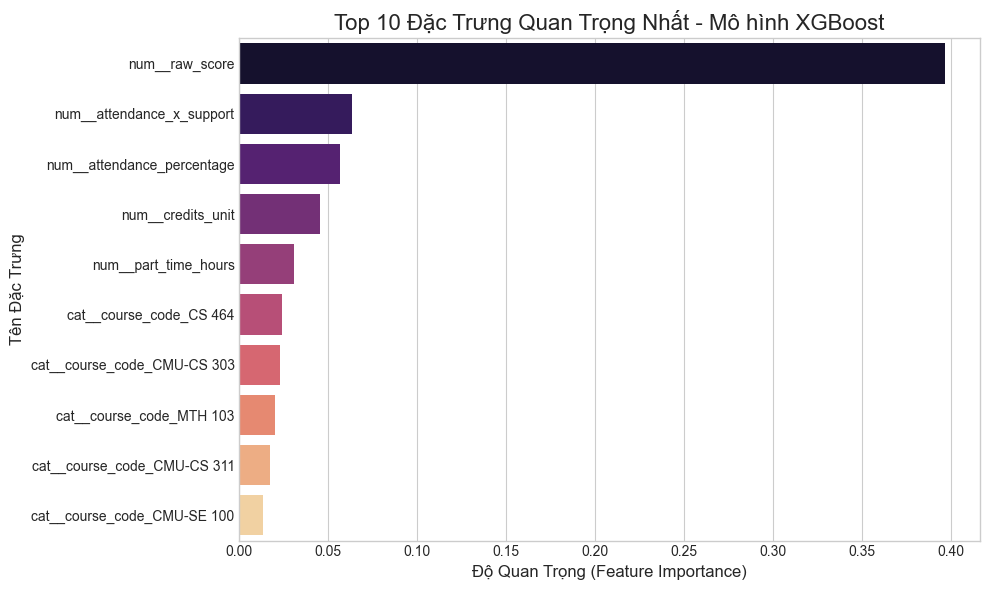

In [10]:
# === PHẦN 6: TOP 10 ĐẶC TRƯNG QUAN TRỌNG NHẤT CỦA XGBOOST ===
importances = best_xgb_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
top_features = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Hiển thị bảng
print("\n--- 🔍 Top 10 đặc trưng quan trọng nhất của mô hình XGBoost ---")
display(top_features.style.format({"Importance": "{:.4f}"}))

# Biểu đồ trực quan
plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='Importance', y='Feature', palette='magma')
plt.title('Top 10 Đặc Trưng Quan Trọng Nhất - Mô hình XGBoost', fontsize=16)
plt.xlabel('Độ Quan Trọng (Feature Importance)', fontsize=12)
plt.ylabel('Tên Đặc Trưng', fontsize=12)
plt.tight_layout()
plt.savefig('XGBoostPermutationImportancev1.png')
plt.show()



--- 🔍 Tính Permutation Importance cho MLPRegressor ---
--- 🔍 Top 10 đặc trưng quan trọng nhất của mô hình MLPRegressor ---


,Feature,Importance
65,num__raw_score,131.3030
66,num__attendance_percentage,18.3261
68,num__family_support,5.7429
67,num__part_time_hours,5.5241
59,cat__study_format_LEC,4.2719
58,cat__study_format_LAB,2.6892
70,num__attendance_x_support,1.0253
61,cat__study_format_REC,0.9615
26,cat__course_code_CS 464,0.2153
42,cat__course_code_MTH 103,0.2117


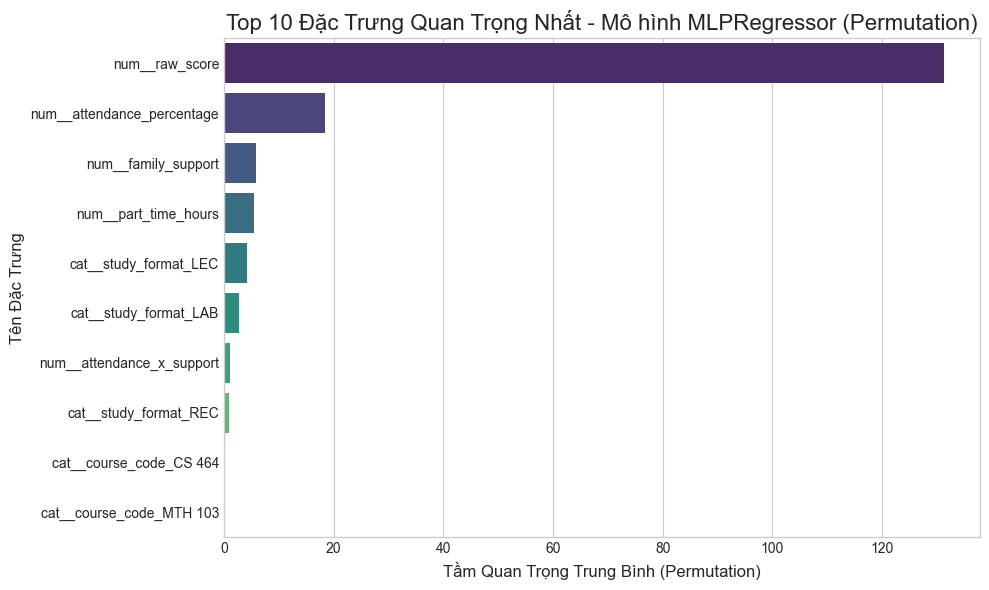

In [11]:
from sklearn.inspection import permutation_importance

# Tính Permutation Importance trên tập kiểm tra
print("\n--- 🔍 Tính Permutation Importance cho MLPRegressor ---")
perm_result = permutation_importance(
    best_mlp_model, X_test, y_test, n_repeats=10,
    random_state=42, n_jobs=-1, scoring='neg_mean_squared_error'
)

# Lưu lại kết quả dưới dạng DataFrame
mlp_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_result.importances_mean
})
top_mlp_features = mlp_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Hiển thị bảng
print("--- 🔍 Top 10 đặc trưng quan trọng nhất của mô hình MLPRegressor ---")
display(top_mlp_features.style.format({"Importance": "{:.4f}"}))

# Biểu đồ trực quan
plt.figure(figsize=(10, 6))
sns.barplot(data=top_mlp_features, x='Importance', y='Feature', palette='viridis')
plt.title('Top 10 Đặc Trưng Quan Trọng Nhất - Mô hình MLPRegressor (Permutation)', fontsize=16)
plt.xlabel('Tầm Quan Trọng Trung Bình (Permutation)', fontsize=12)
plt.ylabel('Tên Đặc Trưng', fontsize=12)
plt.tight_layout()
plt.savefig('MLPRegressorPermutationImportancev1.png')
plt.show()
